<a href="https://colab.research.google.com/github/Goldstein-Berger/law-dmr21-sentence-meaning-annotation/blob/main/dataadv_multilabel_with_synthetic_and_LFs_accuracy_031124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

Already created train and test and sub-labeling functions in undated version of this script

Based upon:  https://colab.research.google.com/github/rap12391/transformers_multilabel_toxic/blob/master/toxic_multilabel.ipynb#scrollTo=Dr7BCHS-nIRW

In [1]:
!pip install sentencepiece

In [2]:
!pip install transformers
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` fr

In [3]:
import pandas as pd


In [4]:
#bert
# Import Tokenizer and pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#!pip install transformers
#from transformers import BertTokenizer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

In [ ]:
main_categories=["Space", "Culture", "Tools", "Workforce_Needs"]

Space=["Aspects", "Amenities", "Lighting", "Interiors", "Exteriors", "Sound", "Windows", "Aesthetics", "Shared_Spaces", "Location", "Furniture"]
Culture=["Interaction_Culture", "Bad_Feelings", "Good_Feelings", "Autonomy"]
Tools=["Technology", "Policy_Benefits", "Supplies", "Video_Conferencing"]
#does misc go into workforce_needs?
Workforce_Needs=["Policy_Benefits", "Health_Safety"]

#Space Subcategories (some of which have labeling functions)
Aspects=["Air_Quality", "Air_Temperature"]
Amenities=["Hall", "Kitchen", "Lobby", "Locker_Room", "Lounge", "Storage", "Basement", "Amenities"]
Lighting=["Lighting_Indoor", "Lighting_Outdoor"]
Interiors=["Ceiling", "Door", "Elevator", "Flooring", "Stairs", "Walls", "Window_Covering"]
Exteriors=["Roof", "Signage", "Main_entrance"]
Sound=["Sound", "Noise", "Acoustics", "Distraction", "Privacy", "Focus", "Music"]
Windows=["Windows", "View", "Natural_Light"]
Aesthetics=["Greenery", "Open_Plan", "Layout", "Aesthetics", "Art", "Design"]
Shared_Spaces=["Meeting_Room", "Team_Room", "Collaboration_Room", "Training_Room", "Project_Room"]
Location=["Commute", "Electric_Vehicles", "Location", "Parking"]
Lighting=["Lighting_Indoor", "Lighting_Outdoor"]
Furniture=["Furniture", "Desk", "Chair", "Cubicle"]

#Culture
Interaction_Culture=["Collaboration", "Communication", "Conversation", "Impromptu", "Interaction", "Team", "Leadership", "Formality", "Productivity"]
Bad_Feelings=["Cramped", "Bad_Culture", "Smell", "Isolation", "Covid_19", "Ailments", "Stress"]
Good_Feelings=["Comfort", "Enjoyment", "Good_Culture", "Trust", "Wellness"]
Autonomy=["Return_To_Office", "Hot_Desk", "Personalization", "Meetings_In_person", "Socialize_In_person", "In_Office_Dislike", "Impromptu"]

#Tools
Technology=["Computer", "Printer_Copier", "Technology", "Video_Conference"]

#Workforce Needs
Health_Safety=["Mold", "Vermin", "Homeless", "Clean_Neat", "Messiness_Or_Unclean", "Security", "Bathrooms", "Handicap"]
Policy_Benefits=["Policy", "Benefits", "Fitness", "Childcare", "Telecommuting", "Food_Drinks", "Learning"]
#Policy_Benefits Sub-Subcategory
Miscellaneous=["Anything", "Everything", "Nothing", "Do_Not_Know"]


In [ ]:
Label_Names=["Acoustics", "Aesthetics", "Ailments", "Air_Quality", "Air_Temperature", "Amenities", "Art", "Bad_Culture", "Basement", "Bathroom",
             "Benefits", "Cafeteria", "Ceiling", "Chair", "Change_Of_Pace", "Childcare", "Clean_Neat", "Collaboration", "Commute",
             "Communication", "Computer", "Conversation", "Covid_19", "Cramped", "Desk", "Door", "Elevator", "Enjoyment",
             "Collaboration_Room", "Comfort", "Communication", "Computer", "Conversation", "Covid_19", "Cramped", "Cubicle",
             "Desk", "Design", "Distraction", "Do_Not_Know", "Door", "Electric_Vehicle", "Elevator", "Enjoyment", "Everything", "Fitness", "Flooring",
             "Focus", "Food_Drink", "Formality", "Furniture", "Good_Culture", "Greenery", "Hall", "Handicap", "Homeless",
             "Hot_Desk", "Impromptu", "In_Office", "Interaction", "Isolation", "Kitchen", "Lactation", "Layout", "Leadership",
             "Learning", "Lighting_Indoor", "Lighting_Outdoor", "Lobby", "Location", "Locker_Room", "Lounge", "Meetings_In_Person",
             "Meeting_Room", "Messiness_Or_Unclean", "Mold", "Music", "Natural_Light", "No", "Noise", "Not_Applicable", "Open_Plan", "Personalization", "Printer_Copier",
             "Privacy", "Productivity", "Return_To_Office", "Roof", "Security", "Signage", "Smell", "Socialize_In_Person", "Stairs", "Storage", "Stress", "Supplies", "Team",
             "Technology", "Telecommuting", "Training_Room", "Trust", "Vermin", "Video_Conference", "View", "Walls", "Window_Covering", "Wellness"]

Acoustics=["acoustics", "acoustic", "echoes", "soundproof", "sound", "sounds", "echo", "accoustics", "accoustic"]
Aesthetics=["aesthetic", "aesthetically", "aesthetics", "atmosphere", "appearance", "attractive", "beautiful", "decor", "decoration", "finishes", "ambiance", "palette", "decor", "decoration", "outdated", "dated", "updating", "older", "age", "refresh", "aged", "uninspired", "sameness", "blah", "ambiance", "retro", "decor", "style", "depressed", "depressing", "environment", "dull", "dazzling", "old", "drab", "out dated", "outdated", "color", "colour", "unattractive", "staid", "colors", "sterile", "outdated", "ikea", "refreshed", "inspiring", "boring", "bland", "stale", "dreary", "modern", "out of date", "80s", "1980s", "1970s", "70s", "1960s", "60s", "updating", "sterile", "ugly", "tattiness", "tacky", "threadbare", "dingy"]
Ailments=["ailments", "migraine", "headache", "migraines", "headaches", "migrane", "migranes", "neck pain", "back pain", "eye strain", "sickness", "sick", "virus", "infection", "covid", "viruses", "sicknesses", "sinus", "sinuses", "allergies", "allergy", "colds", "disease"]
Air_Quality=["pollution", "breathable", "air quality", "ventilation", "dry air", "stuffy", "breathe", "air flow", "fresh air", "freshair", "air vent", "air vents", "unventiliated", "unventilated"]
Air_Temperature=["temperature", "temp", "hot", "climate", "freezing", "cold", "warm", "temperatures", "colder", "coldest", "coldness", "air conditioning", "heating", "ac", "air", "hvac", "air conditioning", "convection", "hot", "dry", "stuffy", "uncomfortable", "cooling", "heat", "heater", "heated", "chilly", "temperture"]
Amenities=["amenities", "amenity"]
Art=["art", "murals", "mural", "sculpture", "branding"]
Basement=["basement", "basements", "cellar", "below ground"]
Bad_Culture=["toxic", "toxicity", "uncaring", "feedback", "autonomy", "fairness", "unfairness", "inequality", "equality", "misogyny", "sexism", "unequitable", "mansplaining", "negative", "dysfunctional", "hostile", "unproductive", "corrosive", "blame", "blaming", "blamed"]
Bathroom=["bathroom", "toilet", "toilets", "bathrooms", "restroom", "plumbing", "towels", "flush", "flushing", "sink", "women's room", "men's room", "women room", "men room", "rest room", "bath room", "bathroom", "restrooms", "urinals", "urinal"]
Benefits=["pto", "time off", "vacation", "health insurance", "401K", "benefits", "paid time off", "profit sharing", "insurance", "leave time"]
Cafeteria=["cafe", "food", "canteen", "cafeteria", "dining room", "cafeterias", "lunchroom", "eatery", "diner", "coffeehouse", "tea point", "tea room"]
Ceiling=["ceiling", "ceilings"]
Chair=["chair", "seat", "sit", "sitting", "sat", "chairs", "seats"]
Change_Of_Pace=["change of pace", "variety of settings", "change of scenery",  "a break from working from home", "a break from telecommuting", "a break from virtual", "a break from telework", "a break from teleworking"]
Childcare=["day care", "daycare", "after school", "afterschool", "child care", "childcare", "preschool", "pre-school"]
Clean_Neat=["cleanliness", "cleaning", "clean", "cleaned", "tidy", "cleanest", "cleaniest", "neat", "neatness", "hygiene", "sanitary", "sanitation", "orderly", "stained", "hygienic", "cleanest", "vacuum", "housekeeping", "cleaners", "cleanliness"]
Collaboration=["collaboration", "collaborate"]
Collaboration_Room=["collaboration room", "collaboration rooms", "collaborative work space", "collaborative work spaces", "collaborative workspace", "collaborative workspaces"]
Comfort=["comfort", "comfy", "cozy", "cushy", "homey", "comfortable", "calming", "chaos", "serene", "serenity", "solace", "cheer"]
Communication=["communication", "communicate", "communicates"]
Commute=["commute", "commuter", "car", "automobile", "subway", "train", "transportation", "vehicles", "station", "metro", "commuting", "traffic", "bike", "bicycle", "moped", "travel", "garage", "parking", "shuttle", "vehicle", "handicap spots", "handicap spot", "handicapped spot", "handicapped spots", "parking spots"]
Computer=["computer", "computers", "desktop", "laptop", "computer", "laptops", "desktops", "keyboard", "mouse", "usb", "docking station", "docking stations", "keyboards", "software", "microsoft", "antivirus", "CPU", "GPU"]
Conversation=["conversation", "chat", "talking", "chatting", "chit", "talk", "socialize", "socializing", "converse", "conversations", "conversing"]
Covid_19=["covid", "covid-19", "covid 19", "coronavirus", "corona", "corona virus", "corona", "n95", "masks", "mask", "vaccines", "vaccinations", "pandemic"]
Cramped=["cramped", "squished", "sardines", "small", "personal space", "insufficient space", "crowded", "overcrowded", "spacious", "cluttered", "openness", "open", "roomy", "enough room", "enclosed", "packed in", "shoebox", "bunched", "crowdedness", "outgrow", "snug"]
Cubicle=["cubicles", "cubicle", "cube", "cubes", "workstation"]
Design=["design", "modern", "designed", "spacious"]
Desk=["desk", "veradesk", "flexistation", "adjustable", "standing desk", "raised desk", "sitstand", "table", "sit to stand desk"]
Distraction=["distraction", "distracting", "distracted", "distractions", "focus", "concentrate", "concentration", "focused", "focusing", "concentrating", "concentrated", "disrupt", "disruption", "distracting", "interruptions", "interruption", "disruptive", "disturbance", "distraction"]
Do_Not_Know=["do not know", "don't know", "unsure", "not sure"]
Door=["door", "doors"]
Electric_Vehicle=["electric vehicle", "electric vehicles", "plug-in stations", "electric vehicle", "charging station", "charging stations", "plug-in stations"]
Elevator=["elevator", "elevators", "escalator", "escalators"]
Enjoyment=["enjoyment", "fun", "happy", "enjoy"]
Everything=["everything"]
Fitness=["gym", "fitness", "workout", "yoga", "wellness", "exercise", "gymnasium", "weights", "treadmill", "treadmills", "peloton", "aerobics", "pilates", "barre", "pools", "swimming", "pool", "onsite fitness"]
Flooring=["carpets", "flooring", "tile floor", "rugs", "carpet", "wood floor", "carpeting", "terrazzo", "rug", "concrete floor", "cork floor"]
Focus=["focus", "concentrate",  "focuses", "concentrate", "concentration", "focused", "focusing", "concentrating", "concentrated"]
Food_Drink=["snacks", "food", "salad", "vending", "snack", "snacks", "drink", "drinks", "ice tea", "soda", "sodapop", "soda pop", "pepsi", "coke", "beverages", "beverage", "juice", "coffee", "espresso",  "nespresso", "keurig"]
Formality=["formality", "formal", "informal"]
Furniture=["furniture", "furnishings", "ergonomic", "ergonomically", "non-ergonomic", "modular furniture", "tables", "booths", "couch", "couches"]
Good_Culture=["energized", "agency", "supportive environment", "recognition", "appreciation", "trustworthy", "caring", "feedback", "good environment", "autonomy", "fairness", "equality", "respect", "equitable", "trust", "emotional support", "supportive environment", "appreciative", "community", "loyalty", "good culture", "positive culture", "excellent culture"]
Greenery=["greenery", "garden", "scenery", "plants", "landscape",  "greenspace", "landscaping", "biofilia", "biophilia", "tree", "trees", "gardens"]
Hall=["hall", "hallway", "halls", "hallways", "corridor", "passageway"]
Handicap=["handicap access", "ADA", "accessible", "accesible", "inclusive design", "universal design"]
Homeless=["homeless", "vagrants", "panhandlers", "waif", "homelessness", "tent city"]
Hot_Desk=["hot desk", "hotdesk", "unassigned desk", "hoteling", "hot-desk", "dedicated seat", "assigned work place", "assigned workplace", "assigned workplace", "assigned desk", "unassigned workplace"]
Impromptu=["spontaneity", "impromptu", "spontaneous", "impromptuness", "unplanned", "not planned"]
In_Office=["in person", "commute", "commuting", "in the office", "come to the office", "coming to the office", "at the office"]
Interaction=["interaction", "engagement", "interacting", "working with the team", "teamwork", "working as a team", "comradery", "cammaraderie", "lunch with co workers", "lunch with coworkers", "socialize", "going to lunch", "build relationships", "impromptu discussions", "impromptu discussion", "can ask questions", "able to ask questions", "can ask a question", "able to ask questions", "interacting", "interactions", "person to person", "side by side", "ask questions", "connecting with co workers", "connecting with coworkers", "connecting with colleagues", "sharing", "meet with colleagues", "meet with my colleagues", "meet with coworkers", "meet with co workers", "catching up", "cooperation", "cooperating", "socializing with my coworkers", "socializing", "friends", "friendship", "feel closer", "closer with colleagues", "closer with coworkers", "closer with co workers"]
Isolation=["isolation", "alienation", "alienated", "bickering", "fighting", "screaming", "isolate", "isolated", "interact", "lonely", "loneliness", "alienating", "disconnected", "disconnection"]
Kitchen=["kitchen", "lunchroom", "breakroom", "microwave", "refrigerator", "dishwasher", "dish washer", "fridge", "pantry", "lunch room", "break room"]
Lactation=["breastfeeding", "breastfeeding", "mothers room", "mother's room", "lactation", "baby", "pumping milk", "mother and baby room", "maternity"]
Layout=["layout", "floorplan", "floor plan", "far away", "spread out", "split up", "separate floor", "far away from team", "distance from the team", "lay out"]
Leadership=["leader", "leaders", "leadership", "management", "manager", "managers", "executives", "c-suite"]
Learning=["learning", "training", "sharing knowledge", "knowledge building", "learn", "courses", "education", "educate"]
Lighting_Indoor=["light", "lighting", "florescent", "eye strain", "bright", "illuminate", "lamp", "light bulb", "lightbulb", "dark", "bright", "glare", "lights", "brighter"]
Lighting_Outdoor=["outdoor lighting", "street lamp", "streetlamp", "street lighting", "parking lighting", "streetlamps", "street lamps", "flood light", "flood lights", "outdoor light", "outdoor lights"]
Lobby=["reception", "lobby", "waiting room", "entrance", "entry", "entranceway", "foyer"]
Location=["commute", "car", "subway", "train", "transportation", "vehicles", "station", "metro", "traffic", "location", "convenient", "bike", "bicycle", "moped", "travel", "restaurants", "stores", "shopping", "city center", "uptown", "downtown", "neighborhoods", "neighborhood", "affordable", "suburban", "suburbs", "schools", "garage", "parking", "shuttle", "vehicle", "handicap spots", "handicap spot", "handicapped spot", "handicapped spots"]
Locker_Room=["locker room", "changing area", "shower", "showers"]
Lounge=["lounge", "lounges", "nap", "sleep", "activity room", "game room", "rest area", "common area", "common space"]
Meetings_In_Person=["in person meetings", "face to face meetings", "meeting in person", "meeting face to face", "in person meeting"]
Meeting_Room=["meeting room", "meeting rooms", "meeting room technology", "meeting room tech", "conference room technology", "conference room tech", "lack of meeting rooms", "lack of conference rooms", "lack of team rooms", "lack of project rooms", "lack of activity rooms", "lack of activities room", "any meeting rooms", "any conference rooms", "lack of available conference rooms", "scheduling conference rooms", "scheduling meeting rooms", "not enough conference rooms", "small meeting rooms", "meeting room technology", "cramped meeting rooms", "meeting room furniture", "small conference room", "small conference rooms", "small meeting room", "conference room technology", "cramped conference room", "conference room furniture", "meetingrooms", "bookable"]
Messiness_Or_Unclean=["messiness", "dirty", "untidy", "unhygienic", "unsanitary", "garbage", "dust", "stains", "cruddy", "stained", "soiled", "sullied", "unclean", "uncleanly", "insanitary", "sordid", "germs", "germy", "tainted"]
Mold=["mold", "mildew", "fungus"]
Music=["music", "muzak"]
Natural_Light=["natural light", "natural lighting", "natural light", "sunlight", "sun light", "window", "windows", "sunshine", "daylight", "day light", "natural lighting"]
No=["no", "none", "nothing", "all good", "can't think of any", "can't think of anything", "cannot think of anything", "cannot think of any"]
Noise=["loud", "noisy", "quiet", "sound", "hear", "noise", "nosiness", "rowdy",  "volume", "noice", "hearing", "noyse", "squeak", "louder", "loudest", "quieter", "quietiest", "quietist", "squeaky"]
Not_Applicable=["not applicable", "n/a"]
Open_Plan=["open space", "open concept", "open design", "open workspace", "open work space", "open spaces", "open environment", "open workplace"]
Personalization=["personalize", "personalization"]
Printer_Copier=["printing", "printer", "print", "scanning", "scanner", "copier", "copy", "copiers", "fax", "scanners", "facsimile"]
Privacy=["private", "privacy", "confidential", "fishbowl", "fish bowl", "confidentiality"]
Productivity=["productivity", "productive"]
Return_To_Office=["return to office", "return to the office", "return to work", "days in office", "days in the office", "flexible working", "flexibility", "face to face", "in-person", "in person", "in office", "seeing co workers", "in the office", "seeing coworkers", "face-to-face", "socializing with co workers", "being with co workers", "seeing my boss", "workhours", "water cooler conversations", "meeting at the water cooler", "seeing people", "around people", "seeing my coworkers", "seeing my co worker", "seeing coworkers in person", "seeing others", "water cooler conversations", "meeting at the water cooler", "seeing colleagues", "see people in person", "communicating in person", "seeing everyone", "seeing my colleagues", "going into the office", "being at the office", "come to the office", "come into the office", "going to work", "being at work", "come in"]
Roof=["roof", "rooves", "rooftop"]
Security=["security", "safety", "unsecure", "alarm", "unsafe"]
Signage=["signs", "directions", "signage", "directory"]
Smell=["smells", "smoke", "formaldehyde", "stinks", "stink", "cigars", "cigar", "cigarette", "cigarettes", "smell", "smelled", "odor", "odors", "odious", "scent", "scents", "aroma", "aromas"]
Socialize_In_Person=["socialize", "socializing", "socialized", "socializing with coworkers", "socialization", "happy hour"]
Stairs=["stairwell", "stairs", "staircase", "banister"]
Storage=["storage", "shelves", "cabinets", "closet", "closets", "drawer", "drawers", "shelf", "belongings", "cabinet", "shelving"]
Stress=["stress", "stressful", "stressed", "stressing", "anxiety", "anxious", "tension", "tense", "fret", "fuss", "worry", "worried", "worrying"]
Supplies=["supplies", "paper", "ink", "post it notes", "postitnotes", "post-it-notes", "stickies", "pens", "pencils"]
Team=["team", "colleague", "department", "division", "group", "squad", "crew", "colleagues", "coworkers", "co-workers", "colleagues"]
Technology=["tech", "technology", "network", "wifi", "internet", "bandwidth", "connectivity", "wi-fi", "monitor", "monitors", "screens", "dual screen", "wide screen"]
Telecommuting=["telecommute", "working from home", "telecommuting", "telecommuted", "teleworking", "working virtually", "home office", "homeoffice", "telework", "virtual work", "remote", "remotely", "work from home", "cyber commuting", "cybercommuting", "hybrid"]
Training_Room=["training room", "training rooms"]
Trust=["trust", "loyalty", "promise"]
Vermin=["insects", "spiders", "spider", "flies", "cockroaches", "bugs", "bug", "roach", "roaches", "mice", "rat", "rats", "rodent", "rodents", "pests", "critters", "mosquito", "mosquitos", "vermin", "mices", "moths", "fruit flies", "mouse"]
Video_Conference=["video conference", "videoconference", "videoconferencing", "headset", "ear buds", "earbuds", "virtual meetings", "teams meetings", "zoom meetings", "virtual meeting", "teams meeting", "AV", "audiovisual", "video", "teleconferencing"]
View=["view", "views", "unobstructed"]
Walls=["wall", "walls", "wallpaper", "paint"]
Window_Covering=["blinds", "shades", "curtain", "curtains", "drapes", "window shade", "drapery"]
Wellness=["wellness", "well being", "happy", "wellbeing", "health", "mindfulness", "happiness", "sedentary", "healthy"]

print(len(Label_Names))
#98
print(len(set(Label_Names)))









107
98


In [ ]:
import pandas as pd


In [ ]:
#create empty dataframe to put in Label Name and LFs

df_LFS = pd.DataFrame(index=range(98))

In [ ]:
#eliminate duplicates
LabeL_Names_cln=set(Label_Names)

In [ ]:

df_LFS["LABEL_NAMES"] = [label for label in LabeL_Names_cln]
df_LFS['Words'] = [eval(labels) for labels in LabeL_Names_cln]


In [ ]:
print(df_LFS.head())

     LABEL_NAMES                                              Words
0        Ceiling                                [ceiling, ceilings]
1      Childcare  [day care, daycare, after school, afterschool,...
2         Lounge  [lounge, lounges, nap, sleep, activity room, g...
3   Conversation  [conversation, chat, talking, chatting, chit, ...
4  Collaboration                       [collaboration, collaborate]


In [ ]:
# ascending
df_LFS_alpha=df_LFS.sort_values('LABEL_NAMES')

In [ ]:
df_LFS_clean=df_LFS_alpha.reset_index(drop=True)
print(df_LFS_clean.shape)

(98, 2)


In [ ]:
display(df_LFS_clean)

,LABEL_NAMES,Words
0,Acoustics,"[acoustics, acoustic, echoes, soundproof, soun..."
1,Aesthetics,"[aesthetic, aesthetically, aesthetics, atmosph..."
2,Ailments,"[ailments, migraine, headache, migraines, head..."
3,Air_Quality,"[pollution, breathable, air quality, ventilati..."
4,Air_Temperature,"[temperature, temp, hot, climate, freezing, co..."
...,...,...
93,Video_Conference,"[video conference, videoconference, videoconfe..."
94,View,"[view, views, unobstructed]"
95,Walls,"[wall, walls, wallpaper, paint]"
96,Wellness,"[wellness, well being, happy, wellbeing, healt..."


In [ ]:
from google.colab import files



df_LFS_clean.to_csv('df_LFS010724.csv')
files.download('df_LFS010724.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
filename = 'df_sub_lfs012024.csv'

df_LFS_clean.to_csv('/content/drive/MyDrive/' + filename)


In [ ]:
#about 2,500 gold labeled by J and L
#path='/content/drive/MyDrive/df_dislike_gld_preprocess__012823_compare_earlier_train.csv'
#path='/content/drive/MyDrive/LF_Main file 230902 (1)_.csv'
#LFs=pd.read_csv(path, encoding="unicode_escape", header=0)

#training data that was not gold labeled but labeled with auto-tagging
path2='/content/drive/MyDrive/df_lst_lke_gold_label_231022.xlsx'

df_dislike_gl=pd.read_excel(path2, header=0, index_col=[0])

#2520 rows
path3='/content/drive/MyDrive/df_synthet111223 (1).csv'
df_synthet=pd.read_csv(path3, encoding="unicode_escape", header=0)
print(df_synthet.shape)

(2520, 100)


In [ ]:
import csv

In [ ]:
for heading in df_dislike_gl:
  print(heading)

#includes response_id
#response
#orig_indx



orig_indx
response_id
response
Acoustics
Aesthetics
Ailments
Air_Quality
Air_Temperature
Amenities
Art
Bad_Culture
Basement
Bathrooms
Benefits
Cafeteria
Ceiling
Chair
Change_of_pace
Childcare
Clean_Neat
Collaboration
Collaboration_room
Comfort
Communication
Commute
Computer
Conversation
Covid_19
Cramped
Cubicle
Desk
Distraction
Do_not_know
Door
Electric_Vehicles
Elevator
Enjoyment
Everything
Fitness
Flooring
Focus
Food_Drinks
Formality
Furniture
Good_Culture
Greenery
Hall
Handicap
Homeless
Hot_Desk
Impromptu
In_Office_dislike
Interaction
Isolation
Kitchen
Lactation
Layout
Leadership
Learning
Lighting_indoor
Lighting_outdoor
Lobby
Location
Locker_Room
Lounge
Meetings_in_person
Meeting_room
Messy_or_unclean
Mold
Music
Natural_Light
No
Noise
Not_applicable
Open_design
Personalization
Printer_Copier
Privacy
Productivity
Return_to_Office
Roof
Security
Signage
Smell
Socialize_in_person
Stairs
Storage
Stress
Supplies
Team
Technology
Telecommuting
Training_room
Trust
Vermin
Video_conference
Vi

In [ ]:
patha='/content/drive/MyDrive/least_like_train_notgl_11_2722_utf8.csv'
#132K Rows
df_lst_like=pd.read_csv(patha, encoding="unicode_escape", header=0)
print(df_lst_like.shape)

<ipython-input-19-8b24f221d5d5>:3: DtypeWarning: Columns (0,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lst_like=pd.read_csv(patha, encoding="unicode_escape", header=0)


(132256, 46)


In [ ]:
df_lst_like.head()

,ï»¿,response,question_category,cleintname,surveytypel,createddate_x,jobnumber,surveyid,question_name,question_text,...,Noise,Open_design,Personalization,Privacy,Technology,Vermin,NO_MATCH,Trans2,createddate_y,how_satisfied
0,61843,The traffic and having to work a walk time int...,like_least,San Luis Obispo County,Pre-Occ,8/29/2017,005.1549.000,SV_74mDMmUJDYYxY0J,99.2_STD,What do you like least about your current work...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,The traffic and having to work a walk time int...,8/29/2017,3.0
1,69252,Too cramped with very few alternative options ...,like_least,Capital One,Pre-Occ,11/11/2016,019.6609.000,SV_0PcXPlG5OWNlQTX,99.2_STD,Tell us what you like least about your current...,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Too cramped with very few alternative options ...,11/11/2016,3.0
2,155218,Socializing/conversing from cubical to cubical...,like_least,Cone Health,WFH,2/10/2021,090.0446.100,SV_7PvUe8Jro1dsPsy,E99.2_WPI,What did you like least about your physical wo...,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Socializing/conversing from cubical to cubical...,2/10/2021,4.0
3,117052,When things don't work - headset for Skype som...,like_least,Aramark,Pre-Occ,4/26/2016,006.9915.830,SV_0MQuD3qLQnrfZDT,j02_OPT,What do you like least about your current work...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,When things don't work - headset for Skype som...,4/26/2016,3.0
4,87180,Open space noise and no privacy,like_least,UNICEF Geneva,Pre-Occ,1/5/2018,008.7548.000,SV_aaWbibEWn3grWpD,99.2_STD,What do you like least about your current work...,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,Open space noise and no privacy,1/5/2018,3.0


In [ ]:
for heading in df_lst_like:
  print(heading)

#has response_id

ï»¿
response
question_category
cleintname
surveytypel
createddate_x
jobnumber
surveyid
question_name
question_text
response_value
response_type
__metadata._dataos_run_mapper_id
_metadata.id
Master_Indx
Lang_Detect
Lang_Confiden
Preprocess3
response_id
Unnamed: 0
match
Preprocess3.1
Air_Quality
Air_Temperature
Bad_Culture
Bathrooms
Chair
Collaboration
Cubicle
Desk
Distraction
Furniture
Hot_Desk
Lounge
Meeting_room
Natural_Light
Noise
Open_design
Personalization
Privacy
Technology
Vermin
NO_MATCH
Trans2
createddate_y
how_satisfied


In [ ]:
#determining if any of the gold label labels don't match current LF labels
# extract a list of ages greater than 30
Label_Names_Lst = df_LFS_clean['LABEL_NAMES'].tolist()
Label_Names_Srtd = sorted(Label_Names_Lst)
print(Label_Names_Srtd)
#print(Label_Names_Lst)
# convert column names to a list
gl_list = df_dislike_gl.columns.tolist()
gl_list_srt=sorted(gl_list)
print(gl_list_srt)

differences = set(Label_Names_Srtd).difference(set(gl_list_srt))

print(differences)



['Acoustics', 'Aesthetics', 'Ailments', 'Air_Quality', 'Air_Temperature', 'Amenities', 'Art', 'Bad_Culture', 'Basement', 'Bathroom', 'Benefits', 'Cafeteria', 'Ceiling', 'Chair', 'Change_Of_Pace', 'Childcare', 'Clean_Neat', 'Collaboration', 'Collaboration_Room', 'Comfort', 'Communication', 'Commute', 'Computer', 'Conversation', 'Covid_19', 'Cramped', 'Cubicle', 'Design', 'Desk', 'Distraction', 'Do_Not_Know', 'Door', 'Electric_Vehicle', 'Elevator', 'Enjoyment', 'Everything', 'Fitness', 'Flooring', 'Focus', 'Food_Drink', 'Formality', 'Furniture', 'Good_Culture', 'Greenery', 'Hall', 'Handicap', 'Homeless', 'Hot_Desk', 'Impromptu', 'In_Office', 'Interaction', 'Isolation', 'Kitchen', 'Lactation', 'Layout', 'Leadership', 'Learning', 'Lighting_Indoor', 'Lighting_Outdoor', 'Lobby', 'Location', 'Locker_Room', 'Lounge', 'Meeting_Room', 'Meetings_In_Person', 'Messiness_Or_Unclean', 'Mold', 'Music', 'Natural_Light', 'No', 'Noise', 'Not_Applicable', 'Open_Plan', 'Personalization', 'Printer_Copier', 

In [ ]:
#align column names
#renaming gold label to current LF names
# create a dictionary
# key = old name
# value = new name
dct = {'Video_conference': 'Video_Conference', 'Food_Drinks': 'Food_Drink', 'Messiness_or_unclean': 'Messiness_Or_Unclean',
        'Window_covering': 'Window_Covering', 'Bathrooms' : 'Bathroom', 'Change_of_pace': 'Change_Of_Pace', 'Collaboration_room': 'Collaboration_Room',
        'Do_not_know': 'Do_Not_Know', 'Electric_Vehicles' : 'Electric_Vehicle', 'Food_Drinks' : 'Food_Drink', 'Lighting_indoor' : 'Lighting_Indoor', 'Lighting_outdoor' : 'Lighting_Outdoor', 'Meetings_in_person' : 'Meetings_In_Person',
        'Meeting_room': 'Meeting_Room', 'In_Office_dislike' : 'In_Office', 'Messy_or_unclean' : 'Messiness_Or_Unclean', 'Not_applicable' : 'Not_Applicable', 'Open_design' : 'Open_Plan', 'Open_Desing' : 'Open_Plan',
        'Return_to_Office' : 'Return_To_Office', 'Socialize_in_Person' : 'Socialize_In_Person', 'Training_room' : 'Training_Room', 'Messy_Or_Unclean' : 'Messiness_Or_Unclean', 'Open_Design' : 'Open_Plan'}

#Video_conference', 'Window_covering'

# call rename () method
df_dislike_gl.rename(columns=dct, inplace=True)
new_column_names = df_dislike_gl.columns.tolist()
#print(new_column_names)
# print Data frame after rename columns
#display(df_dislike_gl)

c = [i for i in new_column_names if i not in Label_Names_Lst]
print(c)

print(new_column_names)
print(Label_Names_Srtd)

['orig_indx', 'response_id', 'response']
['orig_indx', 'response_id', 'response', 'Acoustics', 'Aesthetics', 'Ailments', 'Air_Quality', 'Air_Temperature', 'Amenities', 'Art', 'Bad_Culture', 'Basement', 'Bathroom', 'Benefits', 'Cafeteria', 'Ceiling', 'Chair', 'Change_Of_Pace', 'Childcare', 'Clean_Neat', 'Collaboration', 'Collaboration_Room', 'Comfort', 'Communication', 'Commute', 'Computer', 'Conversation', 'Covid_19', 'Cramped', 'Cubicle', 'Desk', 'Distraction', 'Do_Not_Know', 'Door', 'Electric_Vehicle', 'Elevator', 'Enjoyment', 'Everything', 'Fitness', 'Flooring', 'Focus', 'Food_Drink', 'Formality', 'Furniture', 'Good_Culture', 'Greenery', 'Hall', 'Handicap', 'Homeless', 'Hot_Desk', 'Impromptu', 'In_Office', 'Interaction', 'Isolation', 'Kitchen', 'Lactation', 'Layout', 'Leadership', 'Learning', 'Lighting_Indoor', 'Lighting_Outdoor', 'Lobby', 'Location', 'Locker_Room', 'Lounge', 'Meetings_In_Person', 'Meeting_Room', 'Messiness_Or_Unclean', 'Mold', 'Music', 'Natural_Light', 'No', 'Noise

In [ ]:
#align synthetic data and training data
#df_synthet
df_dislike_trn=df_lst_like

dct = {'Video_conference': 'Video_Conference', 'Food_Drinks': 'Food_Drink', 'Messiness_or_unclean': 'Messiness_Or_Unclean',
        'Window_covering': 'Window_Covering', 'Bathrooms' : 'Bathroom', 'Change_of_pace': 'Change_Of_Pace', 'Collaboration_room': 'Collaboration_Room',
        'Do_not_know': 'Do_Not_Know', 'Electric_Vehicles' : 'Electric_Vehicle', 'Food_Drinks' : 'Food_Drink', 'Lighting_indoor' : 'Lighting_Indoor', 'Lighting_outdoor' : 'Lighting_Outdoor', 'Meetings_in_person' : 'Meetings_In_Person',
        'Meeting_room': 'Meeting_Room', 'In_Office_dislike' : 'In_Office', 'Messy_or_unclean' : 'Messiness_Or_Unclean', 'Not_applicable' : 'Not_Applicable', 'Open_design' : 'Open_Plan', 'Open_Desing' : 'Open_Plan',
        'Return_to_Office' : 'Return_To_Office', 'Socialize_in_Person' : 'Socialize_In_Person', 'Training_room' : 'Training_Room', 'Messy_Or_Unclean' : 'Messiness_Or_Unclean', 'Open_Design' : 'Open_Plan',
        'Socialize_in_person' : 'Socialize_In_Person'}

#Video_conference', 'Window_covering'

# call rename () method
df_dislike_trn.rename(columns=dct, inplace=True)
new_column_names_trn = df_lst_like.columns.tolist()
#print(new_column_names)
# print Data frame after rename columns
#display(df_dislike_gl)

c_trn = [i for i in new_column_names_trn if i not in Label_Names_Lst]
print(c_trn)

print(new_column_names_trn)
print(Label_Names_Srtd)



['ï»¿', 'response', 'question_category', 'cleintname', 'surveytypel', 'createddate_x', 'jobnumber', 'surveyid', 'question_name', 'question_text', 'response_value', 'response_type', '__metadata._dataos_run_mapper_id', '_metadata.id', 'Master_Indx', 'Lang_Detect', 'Lang_Confiden', 'Preprocess3', 'response_id', 'Unnamed: 0', 'match', 'Preprocess3.1', 'NO_MATCH', 'Trans2', 'createddate_y', 'how_satisfied']
['ï»¿', 'response', 'question_category', 'cleintname', 'surveytypel', 'createddate_x', 'jobnumber', 'surveyid', 'question_name', 'question_text', 'response_value', 'response_type', '__metadata._dataos_run_mapper_id', '_metadata.id', 'Master_Indx', 'Lang_Detect', 'Lang_Confiden', 'Preprocess3', 'response_id', 'Unnamed: 0', 'match', 'Preprocess3.1', 'Air_Quality', 'Air_Temperature', 'Bad_Culture', 'Bathroom', 'Chair', 'Collaboration', 'Cubicle', 'Desk', 'Distraction', 'Furniture', 'Hot_Desk', 'Lounge', 'Meeting_Room', 'Natural_Light', 'Noise', 'Open_Plan', 'Personalization', 'Privacy', 'Te

In [ ]:
#align synthetic data and training data
#df_synthet
#df_dislike_trn=df_lst_like

dct = {'Video_conference': 'Video_Conference', 'Food_Drinks': 'Food_Drink', 'Messiness_or_unclean': 'Messiness_Or_Unclean',
        'Window_covering': 'Window_Covering', 'Bathrooms' : 'Bathroom', 'Change_of_pace': 'Change_Of_Pace', 'Collaboration_room': 'Collaboration_Room',
        'Do_not_know': 'Do_Not_Know', 'Electric_Vehicles' : 'Electric_Vehicle', 'Food_Drinks' : 'Food_Drink', 'Lighting_indoor' : 'Lighting_Indoor', 'Lighting_outdoor' : 'Lighting_Outdoor', 'Meetings_in_person' : 'Meetings_In_Person',
        'Meeting_room': 'Meeting_Room', 'In_Office_dislike' : 'In_Office', 'Messy_or_unclean' : 'Messiness_Or_Unclean', 'Not_applicable' : 'Not_Applicable', 'Open_design' : 'Open_Plan', 'Open_Desing' : 'Open_Plan',
        'Return_to_Office' : 'Return_To_Office', 'Socialize_in_Person' : 'Socialize_In_Person', 'Training_room' : 'Training_Room', 'Messy_Or_Unclean' : 'Messiness_Or_Unclean', 'Open_Design' : 'Open_Plan',
        'Socialize_in_person' : 'Socialize_In_Person'}

#Video_conference', 'Window_covering'

# call rename () method
df_synthet.rename(columns=dct, inplace=True)
new_column_names_syn = df_synthet.columns.tolist()
#print(new_column_names)
# print Data frame after rename columns
#display(df_dislike_gl)

c_syn = [i for i in new_column_names_syn if i not in Label_Names_Lst]
print(c_syn)

#print(new_column_names_syn)
#print(Label_Names_Srtd)



['Unnamed: 0', 'response', 'orig_indx']


In [ ]:
#confirm no data leakage
#confirm that no gold label (test set) in training set

gl_ids=df_dislike_gl['response_id'].tolist()
trn_ids=df_dislike_trn['response_id'].tolist()

In [ ]:
#find duplicates
c_leak_detect = [i for i in gl_ids if i  in trn_ids]
print(c_leak_detect)

['R_2uqWxJXFyaZvCmH', 'R_1cZDXzZD4mZ9gj4', 'R_1C76pcMZ3h3wcRj', 'R_1qWoFBEt4ptFuvQ', 'R_1gMapQyOYqCqn3b', 'R_1OxwSUEMAku5rIB', 'R_3wsm5os1fSRRdFD', 'R_eLKOROigiV53vKV', 'R_eQVshvdNWILSzvU', 'R_NUyMMifqdIH2HyF', 'R_3JaxmpPgm4hh5Ts', 'R_agbR6zDGyEGyCQN', 'R_VKLQHVx81ORsxep', 'R_XZ1zNsCfnBXu9kl', 'R_sLjQulJ2arpKhgd', 'R_3lApF71zDjIxCS4', 'R_1QuOFIQUwnMkgKS', 'R_bOPQTuSACS6UmhM', 'R_2wMIVoRv58kx4CR', 'R_pLWGv8Al6paz0Bj', 'R_1IvdCVMvpu7GikZ', 'R_1F5tRd51v1AJNbr', 'R_3MFLqS7HqfsrLpa', 'R_C2DiI6Z5DcV9xbX', 'R_31SJpVcdu8IqnNu', 'R_1MZnGrksfjQiRRq', 'R_3KqndGiHyB2t3Uo', 'R_2wAyKExEvgHd7mX', 'R_3IcwF3tjU1nQIb8', 'R_2OVbQxyR8eQql1P', 'R_3HBQnvMrIi5hkWK', 'R_23nb9nduUSDJGuZ', 'R_1imOkGxBHt0mU0F', 'R_3rOnddBHPVNJv6A', 'R_piTXDAU42zQOUfv', 'R_28IMv8hIWbqae2b', 'R_2TXzShOqE3mLNwe', 'R_56H3dOFqyXqGNjU', 'R_3QPPBpv5ufzefQ7', 'R_2uClv0xAVFeo7ub', 'R_2BbuSVsawZAmvHe', 'R_1ln6BalHrOowDtt', 'R_3MnV4J71EnyIvyj', 'R_2pSoi6yGiGULf5T', 'R_T1VDURyv0apOCDD', 'R_1EYY36lv4PviHuS', 'R_24nOHWDe7BK0TK1', 'R_3JLrvNpO4

In [ ]:
print(len(c_leak_detect))
print(df_dislike_gl.shape)

7654
(10001, 100)


In [ ]:
#sentences from articles
path4='/content/drive/MyDrive/stem_lem021721_caVSco_lg.csv'
df_synthet2=pd.read_csv(path4, encoding="unicode_escape", header=0)
print(df_synthet2.shape)

(926, 8)


In [ ]:
#business book titles that I thought may provide some synthetic data via LFs
path5= '/content/drive/MyDrive/business_bk_titles.csv'
df_synthet3=pd.read_csv(path5, encoding="unicode_escape", header=0)
print(df_synthet3.shape)

(1000, 10)


In [ ]:
print(df_dislike_gl.shape)
#for idx, x in enumerate(xs):
    #print(idx, x)
for i, heading in enumerate(df_dislike_gl):
  print(i, heading)

(10001, 100)
0 orig_indx
1 response_id
2 response
3 Acoustics
4 Aesthetics
5 Ailments
6 Air_Quality
7 Air_Temperature
8 Amenities
9 Art
10 Bad_Culture
11 Basement
12 Bathroom
13 Benefits
14 Cafeteria
15 Ceiling
16 Chair
17 Change_Of_Pace
18 Childcare
19 Clean_Neat
20 Collaboration
21 Collaboration_Room
22 Comfort
23 Communication
24 Commute
25 Computer
26 Conversation
27 Covid_19
28 Cramped
29 Cubicle
30 Desk
31 Distraction
32 Do_Not_Know
33 Door
34 Electric_Vehicle
35 Elevator
36 Enjoyment
37 Everything
38 Fitness
39 Flooring
40 Focus
41 Food_Drink
42 Formality
43 Furniture
44 Good_Culture
45 Greenery
46 Hall
47 Handicap
48 Homeless
49 Hot_Desk
50 Impromptu
51 In_Office
52 Interaction
53 Isolation
54 Kitchen
55 Lactation
56 Layout
57 Leadership
58 Learning
59 Lighting_Indoor
60 Lighting_Outdoor
61 Lobby
62 Location
63 Locker_Room
64 Lounge
65 Meetings_In_Person
66 Meeting_Room
67 Messiness_Or_Unclean
68 Mold
69 Music
70 Natural_Light
71 No
72 Noise
73 Not_Applicable
74 Open_Plan
75 Pe

In [ ]:
#any labels in labeling functions not in gold label
#design was not a label used in gold labels
c_gl_miss = [i for i in Label_Names_Lst if i not in new_column_names]
print(c_gl_miss)

['Design']


In [ ]:
c_synth_miss = [i for i in Label_Names_Lst if i not in new_column_names_syn]
print(c_synth_miss)

['Design']


In [ ]:
#sum up category rows to find then find the gold labels
df_dislike_gl.fillna(0, inplace=True)
df_dislike_gl["SUM"]=df_dislike_gl.iloc[:, 3:].sum(axis=1)

print(df_dislike_gl)


       orig_indx        response_id  \
0         137747  R_2uqWxJXFyaZvCmH   
1           7543  R_1cZDXzZD4mZ9gj4   
2          59362  R_1C76pcMZ3h3wcRj   
3         155040  R_1CBIFUxEHSH5IVV   
4          66130  R_1qWoFBEt4ptFuvQ   
...          ...                ...   
9996       31852  R_2YsoO4m2N7A8DEf   
9997       49178  R_3D5u7dPGi80CQgC   
9998       98571  R_1qWAN5zZhfDBQ8l   
9999      168017  R_1dcZwcAiAM5dDAA   
10000     162475  R_2rNt2ciM2xPdB8s   

                                                response  Acoustics  \
0      The acoustics. I am fortunate to have an offic...        1.0   
1      At times, distractions from offices in close p...        0.0   
2      Limited privacy, difficult to signal that you ...        0.0   
3      Ã¤Â¼ÂšÃ¨Â­Â°Ã¥Â®Â¤Ã£Â€ÂÃ¤Â¼ÂšÃ¨Â­Â°Ã£Â‚Â¹Ã£Âƒ...        0.0   
4      No access to natural light.\nStorage spread ac...        0.0   
...                                                  ...        ...   
9996                              

In [ ]:
df_gl_trim=df_dislike_gl[df_dislike_gl["SUM"]>0]
#840 rows
print(df_gl_trim)

     orig_indx        response_id  \
0       137747  R_2uqWxJXFyaZvCmH   
1         7543  R_1cZDXzZD4mZ9gj4   
2        59362  R_1C76pcMZ3h3wcRj   
3       155040  R_1CBIFUxEHSH5IVV   
4        66130  R_1qWoFBEt4ptFuvQ   
..         ...                ...   
923      96970  R_1r0VKvK2TckKhmb   
925      76559  R_5c228YlvGXypz3P   
926      57191  R_3svIG5YtUDIBi0X   
928     125688  R_2V2SLDhb4lU1FVi   
930      46304  R_1ODgvJIEOklc04d   

                                              response  Acoustics  Aesthetics  \
0    The acoustics. I am fortunate to have an offic...        1.0         0.0   
1    At times, distractions from offices in close p...        0.0         0.0   
2    Limited privacy, difficult to signal that you ...        0.0         0.0   
3    Ã¤Â¼ÂšÃ¨Â­Â°Ã¥Â®Â¤Ã£Â€ÂÃ¤Â¼ÂšÃ¨Â­Â°Ã£Â‚Â¹Ã£Âƒ...        0.0         0.0   
4    No access to natural light.\nStorage spread ac...        0.0         0.0   
..                                                 ...        ...    

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=65def501177269b87faa59d58cbdf343e33192d155f7c7e2b95ca2dcd0f27836
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect
#detect("War doesn't show who's right, just who's left.")

In [ ]:
def lang_detect(text):
  try:
    lang=detect(text)
    if lang == "en":
      return 1
    else:
      return 0
  except:
    return 0


df_gl_trim["Eng_Detect"]= df_gl_trim.apply(lambda x: lang_detect(x['response']), axis=1)

<ipython-input-84-cfad8295234f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gl_trim["Eng_Detect"]= df_gl_trim.apply(lambda x: lang_detect(x['response']), axis=1)


In [ ]:
#this will be the test
df_eng_gl=df_gl_trim[df_gl_trim["Eng_Detect"]==1]
print(df_eng_gl.shape)

(699, 102)


In [ ]:
#takeout gls out of training data

response_id=df_eng_gl["response_id"].tolist()

df_train=df_dislike_trn[~df_dislike_trn.response_id.isin(response_id)]


In [ ]:
print(df_train.shape)

(131704, 46)


In [ ]:
#STOPPED HERE WHAT ABOUT TWO WORD NAMES? Don't USE?

#Workforce_Needs=["Policy_Benefits", "Health_Safety"]
#Workforce Needs
#Health_Safety=["Mold", "Vermin", "Homeless", "Clean_Neat", "Messiness_Or_Unclean", "Security", "Bathrooms", "Handicap"]
#Policy_Benefits=["Policy", "Benefits", "Fitness", "Childcare", "Telecommuting", "Food_Drinks", "Learning", "Miscellaneous"]
#Policy_Benefits Sub-Subcategory
#Miscellaneous=["Anything", "Everything", "Nothing", "Do_Not_Know"]

import itertools
from itertools import chain

#>>> def flatten_chain(matrix):
#...     return list(chain.from_iterable(matrix))
Workforce_Needs_LFs=[]

for itms in Workforce_Needs:
  Workforce_Needs_LFs.append(itms)
  #the series of "try" are to add in any list with the name of the
  #item in the for loop
  try:
    lf_lst=eval(itms)
    print(lf_lst)
    for lf in lf_lst:
      print(lf)
      Workforce_Needs_LFs.append(lf)
      try:
        sub_lfs=eval(lf)
        for sub_lf in sub_lfs:
          Workforce_Needs_LFs.append(sub_lf)
      except:
        pass
  except:
    pass

print(len(Workforce_Needs_LFs))
print(Workforce_Needs_LFs)


#Fin_LFs_Dct=dict.fromkeys("Workforce_Needs_LFs": Workforce_Needs_LFs)

['Policy', 'Benefits', 'Fitness', 'Childcare', 'Telecommuting', 'Food_Drinks', 'Learning', 'Miscellaneous']
Policy
Benefits
Fitness
Childcare
Telecommuting
Food_Drinks
Learning
Miscellaneous
['Mold', 'Vermin', 'Homeless', 'Clean_Neat', 'Messiness_Or_Unclean', 'Security', 'Bathrooms', 'Handicap']
Mold
Vermin
Homeless
Clean_Neat
Messiness_Or_Unclean
Security
Bathrooms
Handicap
164
['Policy_Benefits', 'Policy', 'Benefits', 'pto', 'time off', 'vacation', 'health insurance', '401K', 'benefits', 'paid time off', 'profit sharing', 'insurance', 'leave time', 'Fitness', 'gym', 'fitness', 'workout', 'yoga', 'wellness', 'exercise', 'gymnasium', 'weights', 'treadmill', 'treadmills', 'peloton', 'aerobics', 'pilates', 'barre', 'pools', 'swimming', 'pool', 'onsite fitness', 'Childcare', 'day care', 'daycare', 'after school', 'afterschool', 'child care', 'childcare', 'preschool', 'pre-school', 'Telecommuting', 'telecommute', 'working from home', 'telecommuting', 'telecommuted', 'teleworking', 'working

In [ ]:
Health_Safety_LFs=[]

for itms in Health_Safety:
  Health_Safety_LFs.append(itms)
  #the series of "try" are to add in any list with the name of the
  #item in the for loop
  try:
    lf_lst=eval(itms)
    print(lf_lst)
    for lf in lf_lst:
      print(lf)
      Health_Safety_LFs.append(lf)

  except:
    pass

print(len(Health_Safety_LFs))
print(Health_Safety_LFs)




['mold', 'mildew', 'fungus']
mold
mildew
fungus
['insects', 'spiders', 'spider', 'flies', 'cockroaches', 'bugs', 'bug', 'roach', 'roaches', 'mice', 'rat', 'rats', 'rodent', 'rodents', 'pests', 'critters', 'mosquito', 'mosquitos', 'vermin', 'mices', 'moths', 'fruit flies', 'mouse']
insects
spiders
spider
flies
cockroaches
bugs
bug
roach
roaches
mice
rat
rats
rodent
rodents
pests
critters
mosquito
mosquitos
vermin
mices
moths
fruit flies
mouse
['homeless', 'vagrants', 'panhandlers', 'waif', 'homelessness', 'tent city']
homeless
vagrants
panhandlers
waif
homelessness
tent city
['cleanliness', 'cleaning', 'clean', 'cleaned', 'tidy', 'cleanest', 'cleaniest', 'neat', 'neatness', 'hygiene', 'sanitary', 'sanitation', 'orderly', 'stained', 'hygienic', 'cleanest', 'vacuum', 'housekeeping', 'cleaners', 'cleanliness']
cleanliness
cleaning
clean
cleaned
tidy
cleanest
cleaniest
neat
neatness
hygiene
sanitary
sanitation
orderly
stained
hygienic
cleanest
vacuum
housekeeping
cleaners
cleanliness
['mess

In [ ]:
from google.colab import files



df_eng_gl.to_csv('df_dislike_gl012024.csv')
files.download('df_dislike_gl012024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_train.to_csv('df_dislike_train012024.csv')
files.download('df_dislike_train012024.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
filename = 'df_dislike_gl012024.csv'

df_eng_gl.to_csv('/content/drive/MyDrive/' + filename)


In [ ]:
filename = 'df_dislike_train012024.csv'

df_train.to_csv('/content/drive/MyDrive/' + filename)

In [ ]:
filename = 'df_Sub_LFs012024.csv'

df_train.to_csv('/content/drive/MyDrive/' + filename)

In [ ]:
for heading in LFs:
  print(heading)

NameError: name 'LFs' is not defined

In [ ]:
print((LFs.loc[2:, 1:]))



TypeError: ignored

In [ ]:
verb_tax1.rename(columns={'Category Number': 'Category_Number', 'Category': 'Category_Name', "Verb_x": "Verb", "Freq": "Freq1"}, inplace=True)

In [ ]:
print(type(LFs))
LFs.reset_index(drop=True, inplace=True)
LFs.column_names
print(LFs["Labeling_Function_Words"])

In [ ]:
# prompt: rename all columns in dataframe

LFs.rename(columns={'response': 'text'}, inplace=True)


In [ ]:
print(LFs["Labeling_Function_Words"][2])

KeyError: ignored

In [ ]:
print(LFs.head())

  Broad_Category      Subctegory       Label_Name  \
0          Space       Acoustics        Acoustics   
1          Space       Interiors       Aesthetics   
2       Wellness  Not applicable         Ailments   
3          Space      Facilities      Air_Quality   
4          Space       Interiors  Air_Temperature   

                            Labeling_Function_Words    TUP  
0  acoustics, acoustic, echoes, soundproof, sound...  None  
1  aesthetic, aesthetically, aesthetics, atmosphe...  None  
2  migraine, headache, migraines, headaches, migr...  None  
3  pollution, breathable, air quality, ventilatio...  None  
4  temperature, temp, hot, climate, freezing, col...  None  


In [ ]:
LFs = LFs.set_index(['Label_Name', 'Labeling_Function_Words'])

In [ ]:
#apply labeling functions to training data
print(LFs)
import ast
def LF_Tuple(Label, Words):
  print(Words)
  print(type(Words))
  tup= []
  try:
    words=ast.literal_eval(Words)
    print(type(words))
    tup.append([Label, words])
    return tup
  except:
    tup.append([Label, Words])

LFs['TUP'] = LFs.apply(lambda x: LF_Tuple(x['Label_Name'], x.get('Labeling_Function_Words')), axis=1)
#LFs['TUP'] = LFs.apply(lambda x: LF_Tuple(x['Label_Name'], x['Labeling_Function_Words']), axis=1)





   Broad_Category      Subctegory        Label_Name  \
0           Space       Acoustics         Acoustics   
1           Space       Interiors        Aesthetics   
2        Wellness  Not applicable          Ailments   
3           Space      Facilities       Air_Quality   
4           Space       Interiors   Air_Temperature   
..            ...             ...               ...   
92     Technology  Not applicable  Video_conference   
93          Space      Facilities              View   
94          Space       Interiors             Walls   
95          Space       Interiors   Window_covering   
96          Other          Policy          Wellness   

                             Labeling_Function_Words    TUP  
0   acoustics, acoustic, echoes, soundproof, sound...  None  
1   aesthetic, aesthetically, aesthetics, atmosphe...  None  
2   migraine, headache, migraines, headaches, migr...  None  
3   pollution, breathable, air quality, ventilatio...  None  
4   temperature, temp, hot, c

In [ ]:
from google.colab import files



df1_LFs.to_csv('LFs_exp.csv')
files.download('LFs_exp.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 #make sure categories have the same name
 #will show which column headings don't match
 compare=df_eng_gl.columns.difference(df_train.columns)
 print(compare)
 #for heading in df_dislike_test:
   #print(heading)



Index(['Acoustics', 'Aesthetics', 'Ailments', 'Amenities', 'Art', 'Basement',
       'Benefits', 'Cafeteria', 'Ceiling', 'Change_of_pace', 'Childcare',
       'Clean_Neat', 'Collaboration_room', 'Comfort', 'Communication',
       'Commute', 'Computer', 'Conversation', 'Covid_19', 'Cramped',
       'Do_not_know', 'Door', 'Electric_Vehicles', 'Elevator', 'Eng_Detect',
       'Enjoyment', 'Everything', 'Fitness', 'Flooring', 'Focus',
       'Food_Drinks', 'Formality', 'Good_Culture', 'Greenery', 'Hall',
       'Handicap', 'Homeless', 'Impromptu', 'In_Office_dislike', 'Interaction',
       'Isolation', 'Kitchen', 'Lactation', 'Layout', 'Leadership', 'Learning',
       'Lighting_indoor', 'Lighting_outdoor', 'Lobby', 'Location',
       'Locker_Room', 'Meetings_in_person', 'Messy_or_unclean', 'Mold',
       'Music', 'No', 'Not_applicable', 'Printer_Copier', 'Productivity',
       'Return_to_Office', 'Roof', 'Security', 'Signage', 'Smell',
       'Socialize_in_person', 'Stairs', 'Storage', 'St

## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [ ]:
print('Unique comments: ', df_dislike_train.response_id.nunique() == df_dislike_train.shape[0])
print('Null values: ', df_dislike_train.isnull().values.any())
# df[df.isna().any(axis=1)]

print('Unique comments: ', df_dislike_test.response_id.nunique() == df_dislike_test.shape[0])
print('Null values: ', df_dislike_test.isnull().values.any())

df_null_test= df_dislike_test.isna().any(axis=1)

print(df_dislike_test.head())

Unique comments:  True
Null values:  True
Unique comments:  True
Null values:  False
   Unnamed: 0        response_id  \
0           0  R_6xJLjOI8utYd6gx   
1           1  R_2xGig1T6gS6YipW   
2           2  R_31hZVop7HM3NjpG   
3           3  R_2fCzn1tAHzCqRYg   
4           5  R_299PCPurUypZaPz   

                                              Trans2  Air_Quality  \
0                       Privacy and individual work.            0   
1                          not enough work from home            0   
2  Noise level, lack of personal development time...            0   
3  Sometimes the temperature could be too cold or...            0   
4  The parking.  Sometimes it is very difficult t...            0   

   Air_Temperature  Bad_Culture  Bathrooms  Chair  Collaboration  Cubicle  \
0                0            0          0      0              0        0   
1                0            0          0      0              0        0   
2                0            1          0      0   

In [ ]:
print('average sentence length: ', df_dislike_train.Preprocess3.str.split().str.len().mean())
print('stdev sentence length: ', df_dislike_train.Preprocess3.str.split().str.len().std())

print('average sentence length: ', df_dislike_test.Preprocess3.str.split().str.len().mean())
print('stdev sentence length: ', df_dislike_test.Preprocess3.str.split().str.len().std())


average sentence length:  18.89201022352621
stdev sentence length:  29.0659744448374
average sentence length:  20.161847389558233
stdev sentence length:  37.910330519599356


In [ ]:
for i, heading in enumerate(df_dislike_test):
  print(i, heading)

#for one file that's training and testing
cols_test = df_dislike_test.columns
#catefory columns
label_cols_test = list(cols_test[3:23])
num_labels_test = len(label_cols_test)
print('Label columns: ', label_cols_test)
print(num_labels_test)

#training dataframe
cols_train = df_dislike_train.columns
#catefory columns
label_cols_train = list(cols_train[21:41])
num_labels_train = len(label_cols_train)
print('Label columns: ', label_cols_train)
print(num_labels_train)

0 Unnamed: 0
1 response_id
2 Trans2
3 Air_Quality
4 Air_Temperature
5 Bad_Culture
6 Bathrooms
7 Chair
8 Collaboration
9 Cubicle
10 Desk
11 Distraction
12 Furniture
13 Hot_Desk
14 Lounge
15 Meeting_room
16 Natural_Light
17 Noise
18 Open_design
19 Personalization
20 Privacy
21 Technology
22 Vermin
23 Preprocess3
Label columns:  ['Air_Quality', 'Air_Temperature', 'Bad_Culture', 'Bathrooms', 'Chair', 'Collaboration', 'Cubicle', 'Desk', 'Distraction', 'Furniture', 'Hot_Desk', 'Lounge', 'Meeting_room', 'Natural_Light', 'Noise', 'Open_design', 'Personalization', 'Privacy', 'Technology', 'Vermin']
20
Label columns:  ['Air_Quality', 'Air_Temperature', 'Bad_Culture', 'Bathrooms', 'Chair', 'Collaboration', 'Cubicle', 'Desk', 'Distraction', 'Furniture', 'Hot_Desk', 'Lounge', 'Meeting_room', 'Natural_Light', 'Noise', 'Open_design', 'Personalization', 'Privacy', 'Technology', 'Vermin']
20


122960
                 1_count  0_count  Topic_Percentage  Total_Percentage
topic                                                                
Air_Quality         2838   129406          0.021931          0.023081
Air_Temperature    13779   118465          0.116313          0.112061
Bad_Culture          211   132033          0.001598          0.001716
Bathrooms           6431   125813          0.051116          0.052302
Chair               8414   123830          0.067948          0.068429
Collaboration       3340   128904          0.025911          0.027163
Cubicle             5667   126577          0.044771          0.046088
Desk               11108   121136          0.091699          0.090338
Distraction        13390   118854          0.112659          0.108897
Furniture           2218   130026          0.017058          0.018038
Hot_Desk             193   132051          0.001462          0.001570
Lounge               837   131407          0.006370          0.006807
Meeting_room 

Text(0, 0.5, 'Percentage')

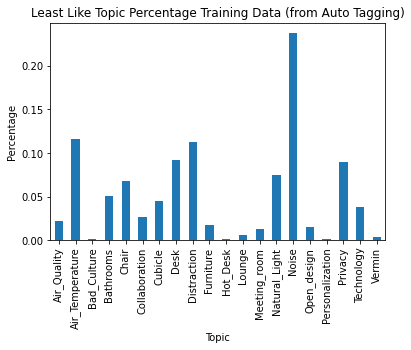

In [ ]:
#print('Count of 1 per label: \n', df_dislike_train[label_cols_train].sum(), '\n') # Label counts, may need to downsample or upsample
#print('Count of 0 per label: \n', df_dislike_train[label_cols_train].eq(0).sum())

# Calculating Percentage
numb_comments=df_dislike_train[label_cols_train].sum()
zero_comments=df_dislike_train[label_cols_train].eq(0).sum()
#print(type(numb_comments))
#print(numb_comments)
#convert series with number of each topic to dataframe
top_count=pd.DataFrame({'topic':numb_comments.index, '1_count':numb_comments.values})
#print(top_count)

top_count.set_index('topic', inplace=True)
zero_count=pd.DataFrame({'topic':zero_comments.index, '0_count':zero_comments.values})


zero_count.set_index('topic', inplace=True)
top_count=pd.concat([top_count, zero_count["0_count"]], axis=1)
#print(top_count)
total_comments=top_count["1_count"].sum()
print(total_comments)
top_count["Topic_Percentage"]=top_count["1_count"]/top_count["0_count"]
top_count["Total_Percentage"]=top_count["1_count"]/total_comments

print(top_count)
top_count["Topic_Percentage"].plot(kind="bar")

from matplotlib import pyplot as plt
top_count['Topic_Percentage'].plot(kind="bar", title="Topic Percentage")
plt.title("Least Like Topic Percentage Training Data (from Auto Tagging)")
plt.xlabel("Topic")
plt.ylabel("Percentage")

In [ ]:
df_train = df_dislike_train.sample(frac=1).reset_index(drop=True) #shuffle rows
df_test=df_dislike_test.sample(frac=1).reset_index(drop=True)



In [ ]:
#need one hot labels to be integers
import numpy as np

#get Ys into a single list
df_train['one_hot_labels'] = list(df_train[label_cols_train].values.astype(np.int64))

df_test['one_hot_labels'] = list(df_test[label_cols_test].values.astype(np.int64))
print(df_test.head())

   Unnamed: 0        response_id  \
0        2028  R_39Fp2XsIYpNVs3f   
1        1608  R_2YxGw5belFJ0U4b   
2        2123  R_u3uJYypEgEvEpXj   
3        1394  R_2PgOCQ4yKapi5oI   
4        1604  R_1rigeTk414vbtV0   

                                              Trans2  Air_Quality  \
0  Lack of large rooms and rooms with technology,...            0   
1  right outside a conference room - very noisy, ...            0   
2  How open it is, this creates a lot of noise th...            0   
3  need more filing space in the office- not outs...            1   
4  Somehow the space is a bit noisier. When on co...            0   

   Air_Temperature  Bad_Culture  Bathrooms  Chair  Collaboration  Cubicle  \
0                0            0          0      0              1        0   
1                0            0          0      0              0        0   
2                0            0          0      0              0        0   
3                1            0          0      0           

In [ ]:
labels_train = list(df_train.one_hot_labels.values)
comments_train = list(df_train.Preprocess3.values)

labels_test = list(df_test.one_hot_labels.values)
comments_test = list(df_test.Preprocess3.values)

Load the pretrained tokenizer that corresponds to your choice in model. e.g.,

```
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


In [ ]:
#BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_positio

In order to avoid memory issues with Google Colab, I enforce a max_length of 100 tokens. Note that some sentences may not adequately represent each label because of this.

In [ ]:
max_length = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments_train, max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_positio

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
input_ids_train = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids_train = encodings['token_type_ids'] # token type ids
attention_masks_train = encodings['attention_mask'] # attention masks

input_ids_test = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids_test = encodings['token_type_ids'] # token type ids
attention_masks_test = encodings['attention_mask'] # attention masks

In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts_train = df_train.one_hot_labels.astype(str).value_counts()
one_freq_train = label_counts_train[label_counts_train==1].keys()
one_freq_idxs_train = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq_train)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs_train)

# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts_test = df_test.one_hot_labels.astype(str).value_counts()
one_freq_test = label_counts_test[label_counts_test==1000].keys()
one_freq_idxs_test = sorted(list(df_test[df_test.one_hot_labels.astype(str).isin(one_freq_test)].index), reverse=True)
print('df label indices with only 1000 instance: ', one_freq_idxs_test)

df label indices with only one instance:  [132235, 132188, 132177, 132093, 132082, 131863, 131363, 131348, 131246, 131235, 131207, 131108, 131009, 130922, 130815, 130796, 130757, 130628, 130567, 130555, 130478, 130456, 130423, 130254, 130219, 129973, 129965, 129807, 129638, 129483, 129385, 129301, 129197, 129070, 129021, 129001, 128975, 128910, 128737, 128732, 128672, 128621, 128606, 128471, 128373, 127745, 127737, 127730, 127573, 127337, 127126, 126976, 126967, 126952, 126899, 126503, 126426, 126354, 126351, 126065, 125980, 125901, 125885, 125653, 125338, 125316, 125154, 124824, 124780, 124269, 124101, 124091, 123976, 123971, 123862, 123741, 123718, 123595, 123437, 123197, 123123, 123042, 123038, 123025, 122954, 122778, 122566, 122370, 122260, 122254, 122209, 122145, 121891, 121780, 121676, 121643, 121612, 121479, 121378, 121376, 121364, 121312, 121263, 121178, 121159, 121105, 121023, 120928, 120896, 120866, 120834, 120592, 120488, 120483, 120440, 120385, 120276, 120269, 120247, 12015

In [ ]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids_train = [input_ids_train.pop(i) for i in one_freq_idxs_train]
one_freq_token_types_train = [token_type_ids_train.pop(i) for i in one_freq_idxs_train]
one_freq_attention_masks_train = [attention_masks_train.pop(i) for i in one_freq_idxs_train]
one_freq_labels_train = [labels_train.pop(i) for i in one_freq_idxs_train]

one_freq_input_ids_test = [input_ids_test.pop(i) for i in one_freq_idxs_test]
one_freq_token_types_test = [token_type_ids_test.pop(i) for i in one_freq_idxs_test]
one_freq_attention_masks_test = [attention_masks_test.pop(i) for i in one_freq_idxs_test]
one_freq_labels_test = [labels_test.pop(i) for i in one_freq_idxs_test]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [ ]:
###not splitting; already split
# Use train_test_split to split our data into train and validation sets

#train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks, random_state=2020, test_size=0.10, stratify = labels)


train_inputs=input_ids_train
train_labels=labels_train
train_masks=token_type_ids_train
train_token_types=attention_masks_train

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids_train)
train_labels.extend(one_freq_labels_train)
train_masks.extend(one_freq_attention_masks_train)
train_token_types.extend(one_freq_token_types_train)



# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

test_inputs=input_ids_test
test_labels=labels_test
test_masks=token_type_ids_test
test_token_types=attention_masks_test

validation_inputs = torch.tensor(test_inputs)
validation_labels = torch.tensor(test_labels)
validation_masks = torch.tensor(test_masks)
validation_token_types = torch.tensor(test_token_types)

<ipython-input-25-a9843a04922b>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  train_labels = torch.tensor(train_labels)


In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
#validation_sampler = SequentialSampler(validation_data)
#validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

Load the appropriate model below, each model already contains a single dense layer for classification on top.



```
BERT:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

XLNet:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)

RoBERTa:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
```



In [ ]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

NameError: ignored

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [ ]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

## Train Model

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

In [ ]:
torch.save(model.state_dict(), 'bert_dislike_gl')

## Load and Preprocess Test Data

In [ ]:
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')
test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])
print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.head()

In [ ]:
test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

In [ ]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.comment_text.values)

In [ ]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

In [ ]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

We need to threshold our sigmoid function outputs which range from [0, 1]. Below I use 0.50 as a threshold.

In [ ]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

## Output Dataframe

In [ ]:
idx2label = dict(zip(range(6),label_cols))
print(idx2label)

In [ ]:
# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [ ]:
# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [ ]:
# Decoding input ids to comment text
comment_texts = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [ ]:
# Converting lists to df
comparisons_df = pd.DataFrame({'comment_text': comment_texts, 'true_labels': true_label_texts, 'pred_labels':pred_label_texts})
comparisons_df.to_csv('comparisons.csv')
comparisons_df.head()

## Bonus - Optimizing threshold value for micro F1 score

Doing this may result in a trade offs between precision, flat accuracy and micro F1 accuracy. You may tune the threshold however you want.

In [ ]:
# Calculate Accuracy - maximize F1 accuracy by tuning threshold values. First with 'macro_thresholds' on the order of e^-1 then with 'micro_thresholds' on the order of e^-2

macro_thresholds = np.array(range(1,10))/10

f1_results, flat_acc_results = [], []
for th in macro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)

best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

f1_results, flat_acc_results = [], []
for th in micro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)

best_f1_idx = np.argmax(f1_results) #best threshold value

# Printing and saving classification report
print('Best Threshold: ', micro_thresholds[best_f1_idx])
print('Test F1 Accuracy: ', f1_results[best_f1_idx])
print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=label_cols)
pickle.dump(clf_report_optimized, open('classification_report_optimized.txt','wb'))
print(clf_report_optimized)